# Final Report on Loan Data

## 1. Introduction
The main objective of this showcase project is to build a predictive model to predict (i) loan status, approve/reject, for potential clients; (ii) credit score variable based on individual and loan-related attributes. <br>
The project uses the [Loan Approval Classification Dataset on Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data?select=loan_data.csv). This report presents steps to achieve this objective. The source code of this project is available at [Github](https://github.com/ant-analytics/Beta.git).

## 2. Discover Data
Import required packages and process to load data then process to discover some information about the data set.

In [8]:
 import sys
sys.path.append('./src') # ensure the src folder in the python path
import warnings
warnings.filterwarnings('ignore')
import os
import time
import datetime
from IPython.display import display, Markdown
from tabulate import tabulate
import tensorflow as tf
import keras_tuner
from keras.utils import plot_model
import matplotlib.pyplot as plt
from src.data_loader import load_data
from src.data_eda import *
from src.model_train import *
from src.hpmodel import *
random_state = 42

# Data loader
raw_data_path = './data/raw_loan_data.csv'
metadata_path = './data/metadata.txt'
raw_data, num_features, cat_features, metadata = load_data(raw_data_path, metadata_path)
metadata.sort_values(by='Type').reset_index(drop=True)
original_indices = raw_data.index # Keep the original indices for later use

There are 10 features in the dataset. Of those, five features are qualitative measurements such as Gender, highest level of education, ownership status, purpose of loan, indicator of previous loan, and loan status (which is presented as an integer data type). The rest of the features are quantitative measurements. Let's do a summary to further discover more information about the dataset.

In [4]:
describe_data(raw_data[num_features]).round(2)

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0
mean,27.764178,80319.053222,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,80422.498632,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.0,8000.0,0.0,500.0,5.42,0.0,2.0,390.0,0.0
25%,24.0,47204.0,1.0,5000.0,8.59,0.07,3.0,601.0,0.0
50%,26.0,67048.0,4.0,8000.0,11.01,0.12,4.0,640.0,0.0
75%,30.0,95789.25,8.0,12237.25,12.99,0.19,8.0,670.0,0.0
max,144.0,7200766.0,125.0,35000.0,20.0,0.66,30.0,850.0,1.0
dtype,float64,float64,int64,float64,float64,float64,float64,int64,int64
NaN count,0,0,0,0,0,0,0,0,0


Firstly, there are no missing values present in the dataset. Secondly, there are differences in the scale of data. For example, the mean age of a person is 28, but the mean income is 80,000. Thirdly, looking closely at the age and years of employment experience, it can be realized that some people are 144 years old and have 125 years of work experience. These numbers are impractical in real life. It is likely that there are unusual data points in the set. These are critical guidelines for the next steps of the project, data preparation.

## Data Preparation
In this project, I will divide the dataset to train, validation and test set with propotion of 50-30-20, respectively. The source code for split function is available at [Github](https://github.com/ant-analytics/Beta.git).


In [5]:
# Data split
from src.data_preprocessing import split_data, preprocess_data, transform_features
X_train, X_val, X_test, y_train_loan_status, y_val_loan_status, y_test_loan_status, y_train_score, y_val_score, y_test_score = split_data(raw_data)
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (21600, 12)
Validation data shape: (14400, 12)
Test data shape: (9000, 12)


As mentioned above, outliers with respect to person age and  are presented in the dataset. These data points should be labeled and remove from the set properly. In this project, I use Isolation Forest method to detect ouliers. Details about isolation forest can be found at [Wikipedia](https://en.wikipedia.org/wiki/Isolation_forest). To do that, I will train a outliers detector on train set, use person age, year of employment experience and length of credit history in years as features to train. 

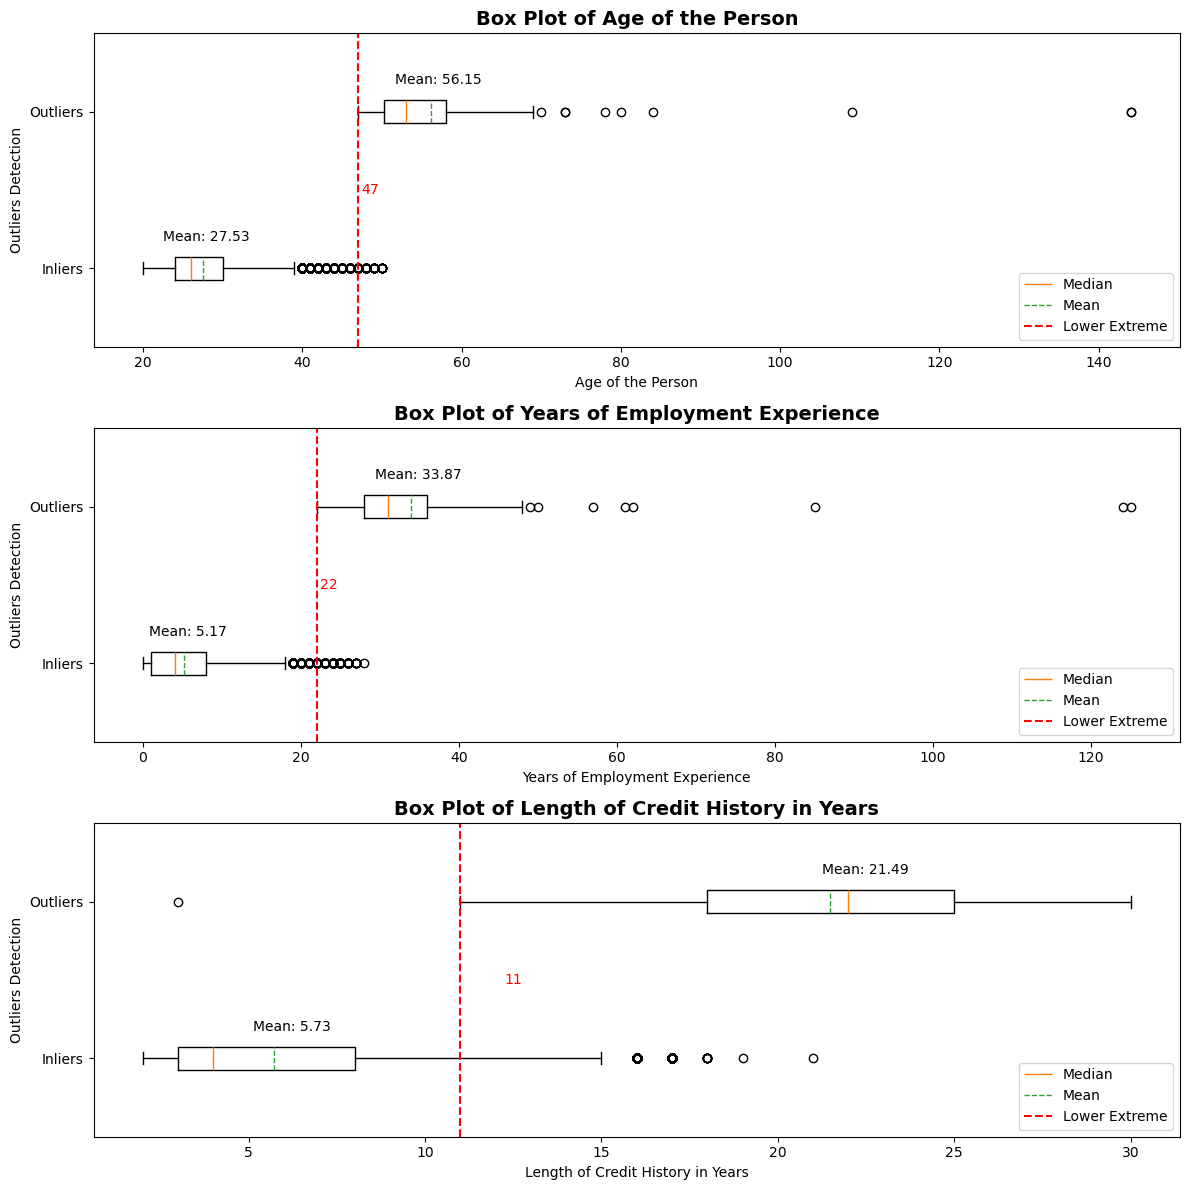

In [ ]:
# outlier detection
from sklearn.ensemble import IsolationForest
outlier_features = ['person_age', 'person_emp_exp', 'cb_person_cred_hist_length']
outlier_detector = IsolationForest(contamination=0.009, random_state=random_state)
X_train['outliers'] = outlier_detector.fit_predict(X_train[outlier_features])
indices_to_remove = X_train[X_train['outliers'] == -1].index # Get the indices of the outliers

# Plot box plot
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
for i, feature in enumerate(X_train[['person_age', 'person_emp_exp', 'cb_person_cred_hist_length']].columns):
    ax = axs[i]
    boxplot = ax.boxplot([X_train[X_train['outliers'] == 1][feature], X_train[X_train['outliers'] == -1][feature]], 
                         labels=['Inliers', 'Outliers'], vert=False, showmeans=True, meanline=True)
    description = metadata.loc[metadata['Feature'] == feature, 'Description'].values[0]
    ax.set_title(f'Box Plot of {description}', fontweight='bold', fontsize=14)
    ax.set_xlabel(f"{description}")
    ax.set_ylabel(f'Outliers Detection')
    
    # Add mean annotation for inliers
    mean_inliers = boxplot['means'][0].get_xdata()[0]
    ax.annotate(f'Mean: {mean_inliers:.2f}', xy=(mean_inliers, 1), xytext=(mean_inliers + 0.5, 1.2),
                horizontalalignment='center', verticalalignment='center')
    
    # Add mean annotation for outliers
    mean_outliers = boxplot['means'][1].get_xdata()[0]
    ax.annotate(f'Mean: {mean_outliers:.2f}', xy=(mean_outliers, 2), xytext=(mean_outliers + 1, 2.2),
                horizontalalignment='center', verticalalignment='center')
    
    # Draw vertical line through min values
    min_outliers = boxplot['caps'][2].get_xdata()[0]
    ax.axvline(min_outliers, color='r', linestyle='--', label='Min Outliers')
    
    # Add tick label for red line
    ax.annotate(f'{min_outliers:.0f}', xy=(min_outliers, 1.5), xytext=(min_outliers + 1.5, 1.5),
                color='red', horizontalalignment='center', verticalalignment='center')
    
    # Add legend for median, mean, and min outliers
    ax.legend([boxplot["medians"][0], boxplot["means"][0], ax.lines[-1]], ['Median', 'Mean', 'Lower Extreme'], loc='lower right')

fig.tight_layout()
plt.show()


As we can see from the plot, the outlier dectector are reasonable to detect outlier in the dataset. We will use this detector to remove outliers from the validation and test set.

In [28]:
# Remove outliers
X_train.drop(index=indices_to_remove, columns='outliers', inplace=True)
y_train_loan_status.drop(labels=indices_to_remove, inplace=True)
y_train_score.drop(labels=indices_to_remove, inplace=True)

# Remove outliers from validation set
X_val['outliers'] = outlier_detector.predict(X_val[outlier_features])
val_indices_to_remove = X_val[X_val['outliers'] == -1].index
X_val.drop(index=val_indices_to_remove, columns='outliers', inplace=True)
y_val_loan_status.drop(labels=val_indices_to_remove, inplace=True)
y_val_score.drop(labels=val_indices_to_remove, inplace=True)

# Remove outliers from test set
X_test['outliers'] = outlier_detector.predict(X_test[outlier_features])
test_indices_to_remove = X_test[X_test['outliers'] == -1].index
X_test.drop(index=test_indices_to_remove, columns='outliers', inplace=True)
y_test_loan_status.drop(labels=test_indices_to_remove, inplace=True)
y_test_score.drop(labels=test_indices_to_remove, inplace=True)

The next step is to preprocess data. Two tasks need to be done: (i) encode categorical variables and (ii) scale numerical variables. For the first task, I will use ordinal endcode method to encode categorical variables. For the second task, I will use standard scaler to scale numerical variables. The source code for these tasks is available at [Github](https://github.com/ant-analytics/Beta.git).

In [29]:
# Data preprocessing
X_train_transform, X_val_transform, X_test_transform, y_train_score_transform, y_val_score_transform, y_test_score_transform, col_transformer, y_scaler = preprocess_data(
    X_train, X_val, X_test, y_train_score, y_val_score, y_test_score, num_features, cat_features)

# keep track features for interpretate
transform_features = transform_features(col_transformer)

## 3. Model Development and Training
The purpose of this project is to predict loan status and credit score. These outputs are different in nature. Loan status is a binary output coded as 1 for approve and 0 for reject. Meanwhile, credit score is a continuous variable. Thus, our problems are classification and regression problems. The predictive models use the same set of input data. A popular choice for this type of problem is to develop two separate models for each problem. However, in this project, I will use a single neural network model to predict both loan status and credit score. The model is a multi-output model. <br>
The next step is to build the model architecture, set up hyperparameters, and train the network. A common approach to developing the network is to start with a reasonable architecture and hyperparameters, then tune them to improve the model performance. But, in this project, I will do it in reverse order. I will start with tuning hyperparameters, then choose the "best" model architecture. From this point, I will train the model and evaluate its performance.

In [ ]:
from src.hpmodel import *
# Hyperparameter tuning
log_dir = f"logs/fit{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Create TensorBoard callback for visualization
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,  
    histogram_freq=1,
    profile_batch='500,520'
)
# early stopping callback for saving time
early_stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_output_status_accuracy',
    patience=3,
    mode='max'
)

callbacks = [tensorboard_callback, early_stop_callback]
 
# Create hyperparameter tuner
tuner = keras_tuner.GridSearch(
    hypermodel=build_hyper_model,
    objective=[
        keras_tuner.Objective('val_output_status_accuracy', direction='max'),
        keras_tuner.Objective('val_output_score_mean_squared_error', direction='min')
    ],
    max_trials=30,
    directory=log_dir,
    project_name='loan_default_prediction',
    overwrite=True
)
# Tuning hyperparameters
tuner.search(
    X_train_transform, y=[y_train_loan_status, y_train_score_transform],
    validation_data=(X_val_transform, [y_val_loan_status, y_val_score_transform]), epochs=10,
    callbacks=callbacks
)

Trial 4 Complete [00h 01m 21s]
multi_objective: 0.04161536693572998

Best multi_objective So Far: 0.03852969408035278
Total elapsed time: 00h 05m 24s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_layers
64                |64                |units
relu              |relu              |activation
adam              |adam              |optimizers
0.0079433         |0.001             |lr

Epoch 1/10
436/669 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3160 - output_score_loss: 0.9953 - output_score_mean_squared_error: 0.9953 - output_status_accuracy: 0.8510 - output_status_loss: 0.3207 - output_status_precision: 0.6972 - output_status_recall: 0.5588

## 4. Conclusion and Discussion 